[*********************100%***********************]  1 of 1 completed

Epoch 1/50



e:\Anaconda\envs\Bilal-2.0\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 2.9411e-04 - val_loss: 0.0055
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.5308e-05 - val_loss: 0.0031
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.2413e-05 - val_loss: 0.0025
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.0657e-05 - val_loss: 0.0029
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9.2027e-06 - val_loss: 0.0028
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.0852e-05 - val_loss: 0.0030
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.1676e-06 - val_loss: 0.0029
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9.1531e-06 - val_loss: 0.0023
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.3554e-06 - val_loss: 0.0030
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.7891e-06 - val_loss: 0.0029
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.6693e-06 - val_loss: 0.0022
Epoch 12/50
35/35 ━━━━━━━━━━━━

C:\Users\Dell\AppData\Local\Temp\ipykernel_8384\3250589319.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


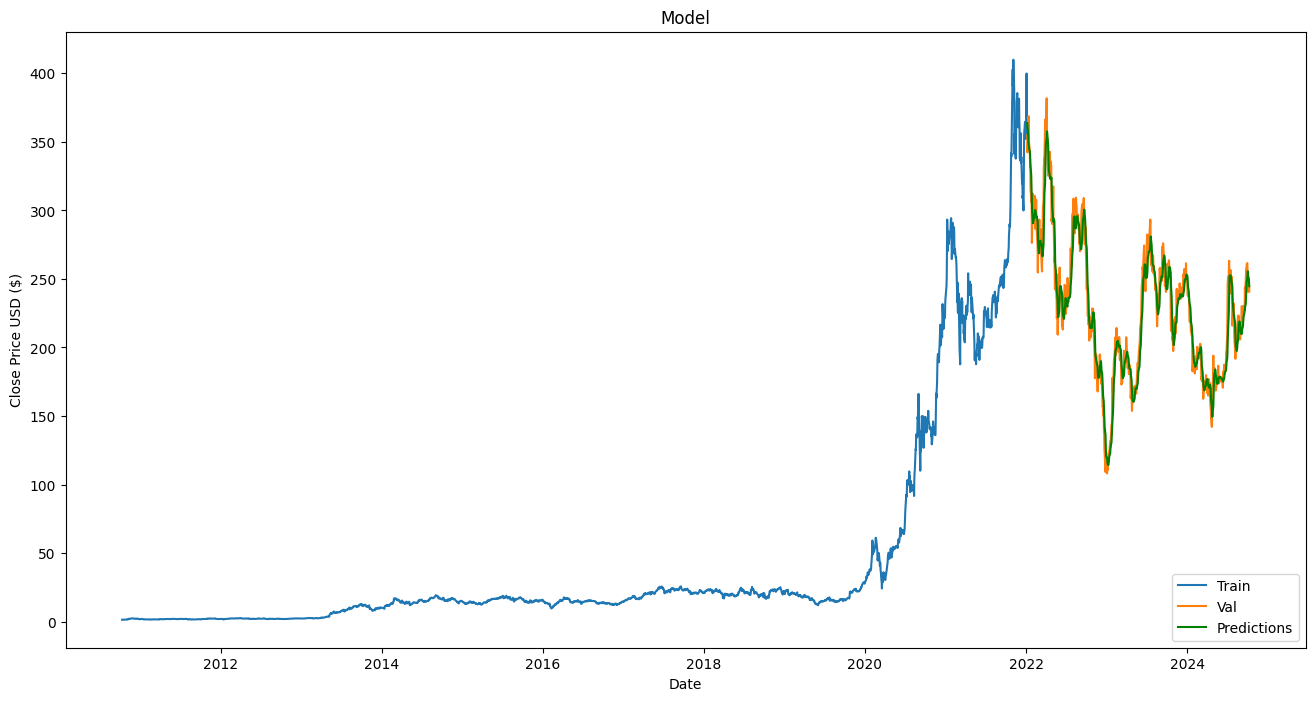

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import math

def load_data(company, start_date, end_date):
    data = yf.download(company, start=start_date, end=end_date)
    return data[['Close']]  # Focus only on 'Close' price for this example

def preprocess_data(data, seq_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i, 0])  # Sequence of 'Close' prices
        y.append(scaled_data[i, 0])  # Predict next 'Close' price
    
    X = np.array(X).reshape(-1, seq_length, 1)  # Reshaping for LSTM input
    y = np.array(y)
    
    return X, y, scaler

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_results(train, valid, predictions):
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Close'])
    plt.plot(valid['Close'], label='Val')
    plt.plot(valid.index, predictions, label='Predictions', color='green')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def main():
    company = 'TSLA'  # Tesla Inc.
    start_date = '2010-10-10'
    end_date = '2024-10-10'
    seq_length = 60
    epochs = 50
    batch_size = 64

    # Load and preprocess data
    data = load_data(company, start_date, end_date)
    X, y, scaler = preprocess_data(data, seq_length)

    # Split data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the model
    model = build_model((seq_length, 1))  # Single feature 'Close'
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint, early_stop])

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions to original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    print(f'RMSE: {rmse}')

    # Prepare data for plotting
    train = data[:split + seq_length]
    valid = data[split + seq_length:]
    valid['Predictions'] = predictions

    # Plot results
    plot_results(train, valid, predictions)

# Execute the main function
if __name__ == "__main__":
    main()
